<a href="https://colab.research.google.com/github/FlaviaLopes/dio-challenges-coding-the-future-with-baires-dev/blob/main/projeto_1/Treinamento_de_redes_neurais_com_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Steps
Uma amostra do dataset CelebA foi utilizada para treinar a rede ResNet50, usando transfer learning.

* 1. _data selection_: o arquivo com os atributos das imagens previamente selecionadas foi carregado. Em seguida o dataset de atributos, usado como referência, foi 'misturado' (efeito shuffle). Os conjuntos de treino, teste e validação também foram criados, na proporção 0,7:0,15:0,15.
[Feature Engineering Celeb A](https://github.com/FlaviaLopes/dio-challenges-coding-the-future-with-baires-dev/blob/main/projeto_1/Feature_Engineering_Celeb_A.ipynb)

* 2. _data preparation_: a partir do dataset referência, as imagens do diretório foram carregadas e devidamente tratadas, sendo reunidas em datasets de imagens do tensorflow.

* 3. _transfer learning_: a rede ResNet50 foi importada com seus pesos oriundos do treinamento com a base `imagenet`, suas camadas foram congeladas, exceto a última, a qual foi adaptada para a saída de classificação deste problema multilabel.

* 4. _evaluation_: os modelos foram brevemente avaliados em função das métricas AUC, Precision e Recall. A função de perda utilizada foi BinaryCrossentropy.

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-multilearn
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, random_rotation
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.regularizers import l2
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.utils import shuffle
from skmultilearn.model_selection import iterative_train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
clear_output()

## helpers
- Funções usadas para preparar os dados e treinar a rede.

In [ ]:
class DatasetManager:
    def __init__(self, img_dir, csv_path, img_size=(224, 224), seed=42):
        """
        Gerencia o carregamento e processamento do dataset para o modelo.

        :param img_dir: Diretório das imagens.
        :param csv_path: Caminho para o arquivo CSV com atributos.
        :param img_size: Dimensão de entrada das imagens (largura, altura).
        :param seed: Semente para reprodutibilidade.
        """
        self.img_dir = Path(img_dir)
        self.csv_path = Path(csv_path)
        self.img_size = img_size
        self.seed = seed
        self.dataframe = None
        self.datasets = {}

    def load(self):
        """
        Carrega o dataset, balanceia as classes e divide em treino, validação e teste.

        :param num_per_class: Número de exemplos positivos e negativos por classe.
        """
        if not self.csv_path.is_file():
            raise FileNotFoundError(f"CSV de atributos não encontrado: {self.csv_path}")
        if not self.img_dir.is_dir():
            raise FileNotFoundError(f"Diretório de imagens não encontrado: {self.img_dir}")

        # Carrega o CSV e pré-processa os dados
        df = pd.read_csv(self.csv_path)
        df['image_id'] = df['image_id'].astype(str)
        df = df.replace(-1, 0)

        # Filtra imagens disponíveis
        available_images = set(os.listdir(self.img_dir))
        df = df[df['image_id'].isin(available_images)]
        self.dataframe = df

    def multilabel_stratified_split(self, test_size=0.3):
        """
        """
        if self.dataframe is None:
            raise ValueError("DataFrame não carregado. Chame o método 'load' antes.")

        X = self.dataframe.loc[:, 'image_id'].values.reshape(-1, 1)
        y = self.dataframe.iloc[:, 1:].values
        X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.3)
        X_test, y_test, X_val, y_val = iterative_train_test_split(X_test, y_test, test_size=0.5)

        train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
        train.columns = self.dataframe.columns
        test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)
        test.columns = self.dataframe.columns
        val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(y_val)], axis=1)
        val.columns = self.dataframe.columns

        self.datasets = {
            'train': train,
            'val': val,
            'test': test
        }

    def create_tf_dataset(self, split='train', augment=False):
        """
        Cria um dataset do TensorFlow para um split específico.

        :param split: Qual split usar (train, val, test).
        :param batch_size: Tamanho do batch.
        :param augment: Se True, aplica augmentação.
        :return: Um objeto tf.data.Dataset.
        """
        if split not in self.datasets:
            raise ValueError(f"Split '{split}' não encontrado. Disponíveis: {list(self.datasets.keys())}")

        def load_image_and_labels(record):
            """
            Carrega uma imagem e seus rótulos correspondentes.
            """
            img_path = str(self.img_dir / record['image_id'])
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, self.img_size) / 255.0

            # Rótulos como lista a partir do dicionário, ignorando 'image_id'
            labels = tf.convert_to_tensor(list(record.values())[1:], dtype=tf.float32)
            return img, labels

        data = self.datasets[split].to_dict(orient='records')
        dataset = tf.data.Dataset.from_generator(
            lambda: (load_image_and_labels(record) for record in data),
            output_signature=(
                tf.TensorSpec(shape=(*self.img_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(len(data[0]) - 1,), dtype=tf.float32)
            )
        )
        if augment:
            data_augmentation = tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal"),
                tf.keras.layers.RandomRotation(0.1),
                tf.keras.layers.RandomZoom(0.1)
            ])
            dataset = dataset.map(
                lambda image, label: (data_augmentation(image, training=True), label),
                num_parallel_calls=tf.data.AUTOTUNE
            )
        return dataset

@register_keras_serializable()
class MultilabelResNet50(Model):
    def __init__(self, num_classes=40, base_trainable=False, **kwargs):
        """
        Modelo para classificação multilabel baseado em ResNet50.

        :param num_classes: Número de classes para classificação.
        :param base_trainable: Se True, a base ResNet50 será treinável (TODO: não suportado ainda.).
        """
        super(MultilabelResNet50, self).__init__(**kwargs)
        self.base_model = ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3)
        )
        self.base_model.trainable = base_trainable
        self.global_pooling = GlobalAveragePooling2D()
        self.batch_norm = BatchNormalization()
        self.dropout = Dropout(0.5)
        self.classifier = Dense(num_classes, activation="sigmoid", kernel_regularizer=l2(0.01), name="classifier")

    def call(self, inputs, training=False):
        """
        Forward pass do modelo.

        :param inputs: Entradas do modelo.
        :param training: Indica se o modelo está em treinamento.
        :return: Predições multilabel.
        """
        x = self.base_model(inputs, training=training)
        x = self.global_pooling(x)
        x = self.batch_norm(x, training=training)
        x = self.dropout(x, training=training)
        outputs = self.classifier(x)
        return outputs

    def get_config(self):
        """
        Retorna a configuração do modelo como um dicionário.
        """
        config = super(MultilabelResNet50, self).get_config()
        config.update({
            "num_classes": self.classifier.units,
            "base_trainable": self.base_model.trainable
        })
        return config

    @classmethod
    def from_config(cls, config):  # Add from_config method
        """
        Cria uma instância do modelo a partir de sua configuração.
        """
        return cls(**config)  # Instantiate the class with the loaded configuration

    def compile_model(self, learning_rate=0.001):
        """
        Compila o modelo com configuração padrão.

        :param learning_rate: Taxa de aprendizado do otimizador.
        """
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=1000,
            decay_rate=0.9
        )
        self.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[
                tf.keras.metrics.AUC(name="auc", multi_label=True),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall")
            ]
        )

    def fit_model(self, train_dataset, val_dataset, steps_per_epoch, validation_steps, epochs=10, batch_size=32, callbacks=None):
        """
        Treina o modelo com os datasets fornecidos.

        :param train_dataset: Dataset de treinamento.
        :param val_dataset: Dataset de validação.
        :param epochs: Número de épocas.
        :param callbacks: Lista de callbacks do Keras.
        :return: Histórico do treinamento.
        """
        if callbacks is None:
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor="auc", patience=3, mode="max", restore_best_weights=True
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    filepath="best_model.keras", monitor="auc", save_best_only=True
                ),
                tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
            ]

        history = self.fit(
            train_dataset,
            validation_data=val_dataset,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        return history

    def fine_tune(self, train_dataset, val_dataset, steps_per_epoch, validation_steps, epochs, initial_epochs, batch_size, learning_rate, layers_to_unfreeze=10):
        """
        Realiza fine-tuning no modelo descongelando as camadas superiores da base.

        :param train_dataset: Dataset de treinamento.
        :param val_dataset: Dataset de validação.
        :param initial_epochs: Número de épocas para treinamento inicial com a base congelada.
        :param fine_tune_epochs: Número total de épocas após descongelar as camadas superiores.
        :param learning_rate: Taxa de aprendizado reduzida para fine-tuning.
        :param layers_to_unfreeze: Número de camadas superiores a serem descongeladas.
        :return: Histórico do treinamento com fine-tuning.
        """
        self.base_model.trainable = True
        for layer in self.base_model.layers[:-layers_to_unfreeze]:
            layer.trainable = False

        self.compile_model(learning_rate=learning_rate)

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="auc", patience=3, mode="max", restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath="best_model.keras", monitor="auc", save_best_only=True
            ),
            tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
        ]

        history_fine_tune = self.fit(
            train_dataset,
            validation_data=val_dataset,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            epochs=epochs,
            initial_epoch=initial_epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
        return history_fine_tune

    def evaluate_model(self, test_dataset, steps):
        """
        Avalia o modelo com o conjunto de teste e salva os resultados.

        :param test_dataset: Dataset de teste.
        :param steps: Número de passos para a avaliação.
        :return: Resultados da avaliação e predições.
        """
        evaluation_per_epoch = self.evaluate(test_dataset, steps=steps, return_dict=True)

        y_true = []
        y_pred = []
        for x, y in test_dataset:
            preds = self.predict(x)
            binarized_preds = (preds > 0.5).astype(int)
            y_true.extend(y.numpy())
            y_pred.extend(binarized_preds)

        import pandas as pd
        predictions = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})

        return evaluation_per_epoch, predictions

    def predict_image(self, image_path):
        """
        Realiza a predição para uma única imagem.

        :param image_path: Caminho para a imagem a ser classificada.
        :return: Classificações da imagem.
        """
        import matplotlib.pyplot as plt

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (224, 224)) / 255.0

        plt.imshow(img.numpy().astype('uint8'))
        plt.axis('off')
        plt.title("Input Image")
        plt.show()

        img = preprocess_input(img)
        img = tf.expand_dims(img, axis=0)
        predictions = self.predict(img)
        binarized_predictions = (predictions > 0.5).astype(int)
        return binarized_predictions

def plot_training_finetune_history_grid(history:dict, fine_tune_point, save_as=''):
    """
    Plota as métricas de treinamento e validação ao longo das épocas em uma grade 2x2.

    :param history: Objeto retornado por model.fit() contendo histórico do treinamento.
    """
    metrics = [m for m in history.keys() if not m.startswith('val_')]
    val_metrics = [f"val_{m}" for m in metrics]

    num_metrics = len(metrics)
    rows, cols = 2, 2

    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.flatten()

    for i, (metric, val_metric) in enumerate(zip(metrics, val_metrics)):
        ax = axes[i]
        ax.plot(history[metric], label=f'Treinamento - {metric}')
        ax.plot(history[val_metric], label=f'Validação - {val_metric}')
        ax.set_title(f'{metric.capitalize()} por Época')
        ax.set_xlabel('Épocas')
        ax.set_ylabel(metric.capitalize())
        ax.legend()
        ax.grid(True)

        ax.axvline(fine_tune_point - 1, color='gray', linestyle='--', label='Fine-tuning start')

    # Remove eixos vazios se houver menos de 4 métricas
    for i in range(num_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    if save_as:
        plt.savefig(save_as)
    plt.show()

## Settings

In [ ]:
base_dir = "base_dir"
csv_attributes_path = os.path.join(base_dir, 'datasets/celeb_a/attr_celeb_a_sample.csv')
img_dir = os.path.join(base_dir, 'datasets/celeb_a/celeb_a_images')

VAR = {
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 64,
    'EPOCHS': 10,
    'FINE_TUNE_EPOCHS': 30,
    'SEED': 42,
    'LEARNING_RATE': 0.001,
    'LEARNING_RATE_FINE_TUNE': 1e-5,
    'NUM_CLASSES': 38
}

## Data preparation
A classe DatasetManager é responsável por todo o pipeline de dados.

`.load()` lê o arquivo de atributos das imagens; `.multilabel_stratified_split()` utiliza skmultilearn para divisão multilabel estratificada; `.create_tf_dataset()` carrega e prepara os conjuntos de imagens.

In [ ]:
dataset_manager = DatasetManager(img_dir=img_dir, csv_path=csv_attributes_path)
dataset_manager.load()
dataset_manager.dataframe.shape

(3800, 39)

Classe menos representada: Bald = 234
Classe mais representada: Young = 2681


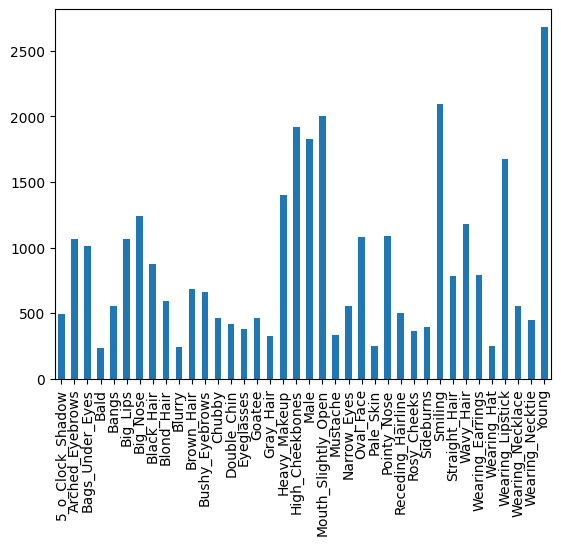

In [ ]:
print(f'Classe menos representada: {dataset_manager.dataframe.columns[1:][dataset_manager.dataframe.iloc[:, 1:].sum().argmin()]} = {dataset_manager.dataframe.iloc[:, 1:].sum().min()}')
print(f'Classe mais representada: {dataset_manager.dataframe.columns[1:][dataset_manager.dataframe.iloc[:, 1:].sum().argmax()]} = {dataset_manager.dataframe.iloc[:, 1:].sum().max()}')
dataset_manager.dataframe.iloc[:, 1:].sum().plot(kind='bar');

In [ ]:
%%time
dataset_manager.multilabel_stratified_split()
train_dataset = dataset_manager.create_tf_dataset(split='train', augment=True).cache()
val_dataset = dataset_manager.create_tf_dataset(split='val', augment=False).cache()
test_dataset = dataset_manager.create_tf_dataset(split='test', augment=False).cache()

CPU times: user 1.64 s, sys: 241 ms, total: 1.88 s
Wall time: 2.32 s


In [ ]:
[f"{k}: {v.shape}" for k, v in dataset_manager.datasets.items()]

['train: (2648, 39)', 'val: (576, 39)', 'test: (576, 39)']

In [ ]:
# Desvio relativo à média: treino, validação e teste possuem a mesma distribuição de classes.
[f"{k}: {np.std(np.sum(v.iloc[:, 1:].values, axis=0)) / np.mean(np.sum(v.iloc[:, 1:].values, axis=0))}" for k, v in dataset_manager.datasets.items()]

['train: 0.6904423637419538',
 'val: 0.6970774374851487',
 'test: 0.6999129495522499']

## Modelling

A classe MultilabelResNet50 é responsável por todo o pipeline de treino da rede. Nesse problema a rede será treinada por 10 épocas e depois suas últimas camadas serão descongeladas para ajuste, e o treino continuará por mais 20 épocas a uma taxa de aprendizado um pouco menor com decaimento.

In [ ]:
%%time
model = MultilabelResNet50(num_classes=VAR['NUM_CLASSES'], base_trainable=False)

steps_per_epoch = int(np.ceil(dataset_manager.datasets['train'].shape[0] / VAR['BATCH_SIZE']))
validation_steps = int(np.ceil(dataset_manager.datasets['val'].shape[0] / VAR['BATCH_SIZE']))

model.compile_model(learning_rate=VAR['LEARNING_RATE'])
history = model.fit_model(
    train_dataset.repeat().batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    val_dataset.repeat().batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    steps_per_epoch,
    validation_steps,
    epochs=VAR['EPOCHS'],
    batch_size=VAR['BATCH_SIZE'],
)

history_fine_tune = model.fine_tune(
    train_dataset.repeat().batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    val_dataset.repeat().batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    steps_per_epoch,
    validation_steps,
    epochs=VAR['FINE_TUNE_EPOCHS'],
    initial_epochs=VAR['EPOCHS'],
    batch_size=VAR['BATCH_SIZE'],
    learning_rate=VAR['LEARNING_RATE_FINE_TUNE'],
    layers_to_unfreeze=10
)

model.save(os.path.join(base_dir, 'projeto_1/output/models/ResNet50_CelebA.keras'))

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1538s 36s/step - auc: 0.5248 - loss: 1.1757 - precision: 0.2609 - recall: 0.4836 - val_auc: 0.6246 - val_loss: 0.6553 - val_precision: 0.4432 - val_recall: 0.3029
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 379ms/step - auc: 0.6188 - loss: 0.6075 - precision: 0.5742 - recall: 0.3200 - val_auc: 0.6590 - val_loss: 0.5382 - val_precision: 0.5784 - val_recall: 0.2101
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step - auc: 0.6687 - loss: 0.5155 - precision: 0.6410 - recall: 0.3056 - val_auc: 0.6742 - val_loss: 0.5132 - val_precision: 0.5921 - val_recall: 0.2931
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - auc: 0.6735 - loss: 0.4953 - precision: 0.6362 - recall: 0.3083 - val_auc: 0.6822 - val_loss: 0.5043 - val_precision: 0.5907 - val_recall: 0.2925
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - auc: 0.6727 - loss: 0.4880 - precision: 0.6357 - recall: 0.3024 - val_auc: 0.6855 - val_loss: 0.4990 - val_precision: 0.5855 - val_recall: 0.

In [ ]:
plot = dict()
for k in history.history.keys():
    plot[k] = history.history[k] + history_fine_tune.history[k]
pd.DataFrame(plot).to_csv(os.path.join(base_dir, 'projeto_1/output/ResNet50_CelebA_training_finetune_history.csv'), index=False)

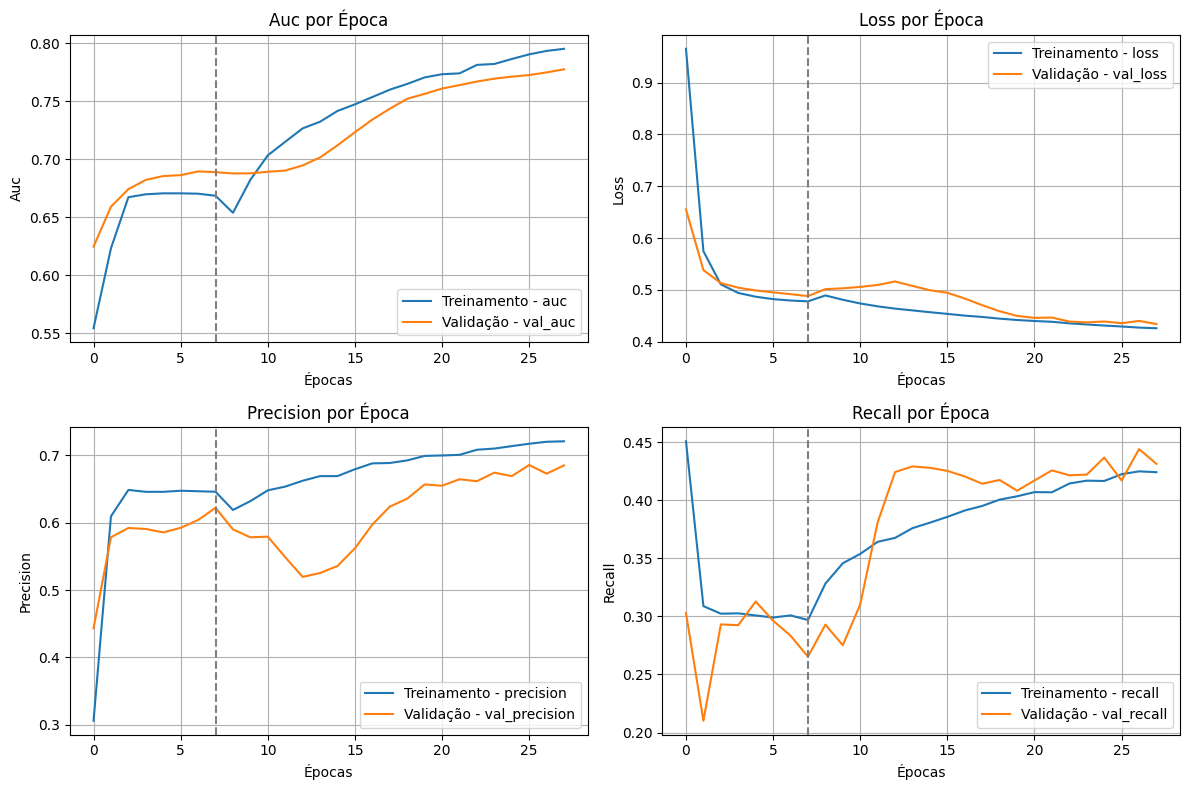

In [ ]:
plot_training_finetune_history_grid(
    history=plot,
    fine_tune_point=len(history.history['auc']),
    save_as=os.path.join(base_dir, 'projeto_1/output/images/ResNet50_CelebA_training_finetune_history.png')
)

## Evaluation

In [ ]:
steps = int(np.ceil(dataset_manager.datasets['test'].shape[0] / VAR['BATCH_SIZE']))
evaluation_per_epoch, predictions = model.evaluate_model(
    test_dataset.batch(VAR['BATCH_SIZE']).prefetch(tf.data.AUTOTUNE),
    steps=steps
)

9/9 ━━━━━━━━━━━━━━━━━━━━ 265s 29s/step - auc: 0.7746 - loss: 0.4331 - precision: 0.6608 - recall: 0.4326
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [ ]:
print(evaluation_per_epoch)
display(predictions.head())

{'auc': 0.7761638164520264, 'loss': 0.4326319694519043, 'precision': 0.6654332280158997, 'recall': 0.43960073590278625}


,y_true,y_pred
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
predictions.to_csv(os.path.join(base_dir, 'assets/ResNet50_CelebA_predictions.csv'), index=False)

## Predicting a random image

In [ ]:
df = pd.read_csv(os.path.join(base_dir, 'datasets/celeb_a/attr_celeb_a_sample.csv')).replace(-1, 0)
df = df[df['image_id'].isin(set(os.listdir(img_dir)))].reset_index(drop=True)

In [ ]:
model = tf.keras.models.load_model(
    os.path.join(base_dir, 'projeto_1/output/models/ResNet50_CelebA.keras'),
    custom_objects={'MultilabelResNet50': MultilabelResNet50}
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 433 variables whereas the saved optimizer has 33 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


__Lena__: Ao testar na imagem da Lena, o modelo retornou que é: atraente, sem barba, face oval, nariz pontiagudo, usa batom e é jovem. De fato isto está correto. Mas o modelo também disse que ela: usa franja e óculos, o que está errado. Já lábios grandes e maquiagem forte é mais difícil de estabelecer se acertou ou não.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


,Prediction
Blond_Hair,1
Heavy_Makeup,1
High_Cheekbones,1
Mouth_Slightly_Open,1
Pointy_Nose,1
Rosy_Cheeks,1
Smiling,1
Wavy_Hair,1
Wearing_Lipstick,1
Young,1


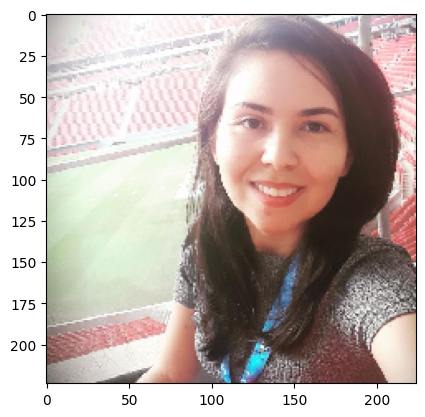

In [ ]:
from keras.preprocessing import image
img = image.load_img(os.path.join(base_dir, 'assets/images/eu.jpg'), target_size=(224,224))
x= image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.imshow(img)
p = pd.Series((model.predict(x)[0] > 0.5).astype(int), index=df.columns[1:], name='Prediction')
p[p == 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


,Prediction
Big_Nose,1
Blond_Hair,1
Heavy_Makeup,1
High_Cheekbones,1
Mouth_Slightly_Open,1
Oval_Face,1
Pointy_Nose,1
Rosy_Cheeks,1
Smiling,1
Wearing_Hat,1


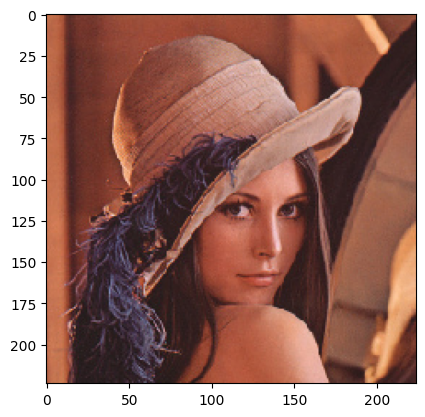

In [ ]:
img = image.load_img(os.path.join(base_dir, 'assets/images/lena.jpg'), target_size=(224,224))
x= image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.imshow(img)
p = pd.Series((model.predict(x)[0] > 0.5).astype(int), index=df.columns[1:], name='Prediction')
p[p == 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


,Prediction
Arched_Eyebrows,1
Blond_Hair,1
Heavy_Makeup,1
High_Cheekbones,1
Mouth_Slightly_Open,1
Pointy_Nose,1
Rosy_Cheeks,1
Smiling,1
Wavy_Hair,1
Wearing_Hat,1


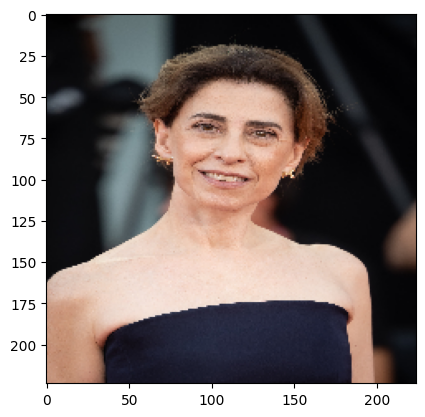

In [ ]:
img = image.load_img(os.path.join(base_dir, 'assets/images/fernanda-torres.jpg'), target_size=(224,224))
x= image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.imshow(img)
p = pd.Series((model.predict(x)[0] > 0.5).astype(int), index=df.columns[1:], name='Prediction')
p[p == 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


,Prediction
Bald,1
Big_Nose,1
Blond_Hair,1
Chubby,1
Double_Chin,1
Eyeglasses,1
Gray_Hair,1
Heavy_Makeup,1
Mouth_Slightly_Open,1
Mustache,1


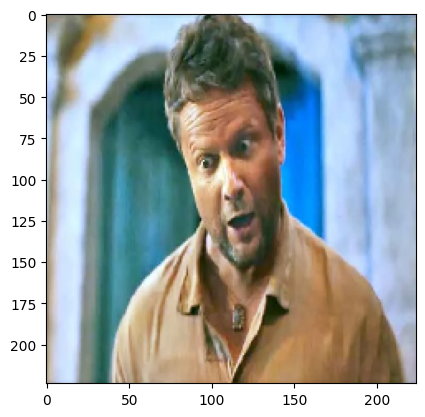

In [ ]:
img = image.load_img(os.path.join(base_dir, 'assets/images/selton-mello.jpg'), target_size=(224,224))
x= image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

plt.imshow(img)
p = pd.Series((model.predict(x)[0] > 0.5).astype(int), index=df.columns[1:], name='Prediction')
p[p == 1]